# Preparing data


### Imports

In [18]:
import sys
from pathlib import Path

# Add parent directory to path for src imports
sys.path.insert(0, str(Path().cwd().parent))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm

# Import from src modules
from src import (
    # Utils
    save_fig,
    CUSTOM_PALETTE_6 as custom_palette_6,
    plot_gene_expression_by_class,
    # Feature engineering
    LibraryLengthNormalizer,
    # Preprocessing
    process_featurecounts_files,
    clean_counts,
    normalize_rpm,
    prepare_training,
)

In [3]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 400)
pd.set_option("display.precision", 5)
pd.set_option("display.max_seq_items", 50)
pd.set_option("display.max_seq_items", 50)

### Custom functions

In [5]:
from adjustText import adjust_text
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropDuplicateFeatures,
)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE


random_state = np.random.RandomState(42)

# LibraryLengthNormalizer now imported from src

en = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=42)

pipe = Pipeline(
    [
        (
            "drop_duplicates",
            DropDuplicateFeatures(),
        ),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        ("select_k_best", SelectKBest(chi2, k=1000)),
        ("select_forest", SelectFromModel(en, threshold=0.001, max_features=250)),
        ("standard_scale", StandardScaler()),
    ]
)
le = LabelEncoder()

In [ ]:
# featurecounts_dir = "/home/t.afanasyeva/MAT_rebase/results/featurecounts"
# df = process_featurecounts_files(featurecounts_dir)

In [ ]:
df = pd.read_csv(
    "/home/t.afanasyeva/MAT_rebase/results/MATseq_count_summary.csv",
    sep="\t",
    index_col=0,
)

In [12]:
df.head()

,BA028_7128_IMDM_01,BA028_7128_IMDM_02,BA028_7128_LPS_05,BA028_7128_LPS_06,BA028_7128_LPS_07,BA028_7128_Pam3_09,BA028_7128_Pam3_10,BA028_7128_Pam3_11,BA028_7128_R848_13,BA028_7128_R848_15,...,MD260_7128_PGN_15,MD260_7128_PGN_16,MD260_7128_PGN_17,MD260_7128_PGN_7,MD260_7128_PGN_8,MD260_7128_PGN_9,MD260_7128_Pam3_3,MD260_7128_Pam3_4,MD260_7128_Pam3_5,MD260_7128_Pam3_6
Geneid,,,,,,,,,,,,,,,,,,,,,
A1BG,6,4,16,22,16,10,10,3,6,2,...,15,3,6,18,12,9,9,19,10,12
A1BG-AS1,2,0,2,4,5,5,6,0,0,2,...,2,3,4,4,2,1,7,2,6,9
A1CF,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
A2M,2,4,1,9,2,2,6,1,12,5,...,5,4,2,14,5,5,5,8,10,12
A2M-AS1,0,0,0,0,2,0,0,0,1,0,...,1,0,1,1,0,2,2,0,0,0


In [22]:
clean_df = clean_counts(df)
normalized_df = normalize_rpm(clean_df)

In [28]:
normalized_df.head()

Geneid,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2MP1,A3GALT2,A4GALT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
samples,,,,,,,,,,,,,,,,,,,,,
BA028_7128_IMDM_01,2.53301,0.84434,0.00000,0.84434,0.00000,0.42217,0.0,0.0,0.00000,3.37735,...,19.41974,2.53301,8.44336,18.15323,64.16957,0.84434,31.24045,272.72067,172.66680,33.77346
BA028_7128_IMDM_02,2.01151,0.00000,0.50288,2.01151,0.00000,2.01151,0.0,0.0,0.50288,3.52015,...,10.56044,2.51439,10.56044,24.13814,63.36262,0.00000,24.13814,251.94186,181.53895,48.27629
BA028_7128_LPS_05,7.26129,0.90766,0.00000,0.45383,0.00000,0.00000,0.0,0.0,0.00000,0.90766,...,16.79173,2.72298,12.70726,24.05303,58.54416,1.36149,18.15323,202.40848,158.84073,39.48327
BA028_7128_LPS_06,3.70449,0.67354,0.16839,1.51547,0.00000,0.50516,0.0,0.0,0.00000,1.01031,...,12.62893,2.02063,7.74574,18.85920,55.73568,0.33677,21.21660,186.40302,162.49224,40.74935
BA028_7128_LPS_07,3.71726,1.16164,0.00000,0.46466,0.46466,0.00000,0.0,0.0,0.23233,0.46466,...,16.49536,2.32329,8.59617,18.81865,47.85977,0.00000,16.72769,207.23747,129.17492,32.75839


In [35]:
normalized_df.index

Index(['BA028_7128_IMDM_01', 'BA028_7128_IMDM_02', 'BA028_7128_LPS_05',
       'BA028_7128_LPS_06', 'BA028_7128_LPS_07', 'BA028_7128_Pam3_09',
       'BA028_7128_Pam3_10', 'BA028_7128_Pam3_11', 'BA028_7128_R848_13',
       'BA028_7128_R848_15',
       ...
       'MD260_7128_PGN_15', 'MD260_7128_PGN_16', 'MD260_7128_PGN_17',
       'MD260_7128_PGN_7', 'MD260_7128_PGN_8', 'MD260_7128_PGN_9',
       'MD260_7128_Pam3_3', 'MD260_7128_Pam3_4', 'MD260_7128_Pam3_5',
       'MD260_7128_Pam3_6'],
      dtype='object', name='samples', length=133)

In [ ]:
labels = pd.DataFrame(index=normalized_df.index)
labels["label"] = [i.split("_")[2] for i in normalized_df.index]

Before feature selection

In [17]:
processed_data = pipe.fit_transform(normalized_df, labels)
training_labels_int = le.fit_transform(labels["label"].to_numpy())
X_reduced = PCA(n_components=2).fit_transform(processed_data)

/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


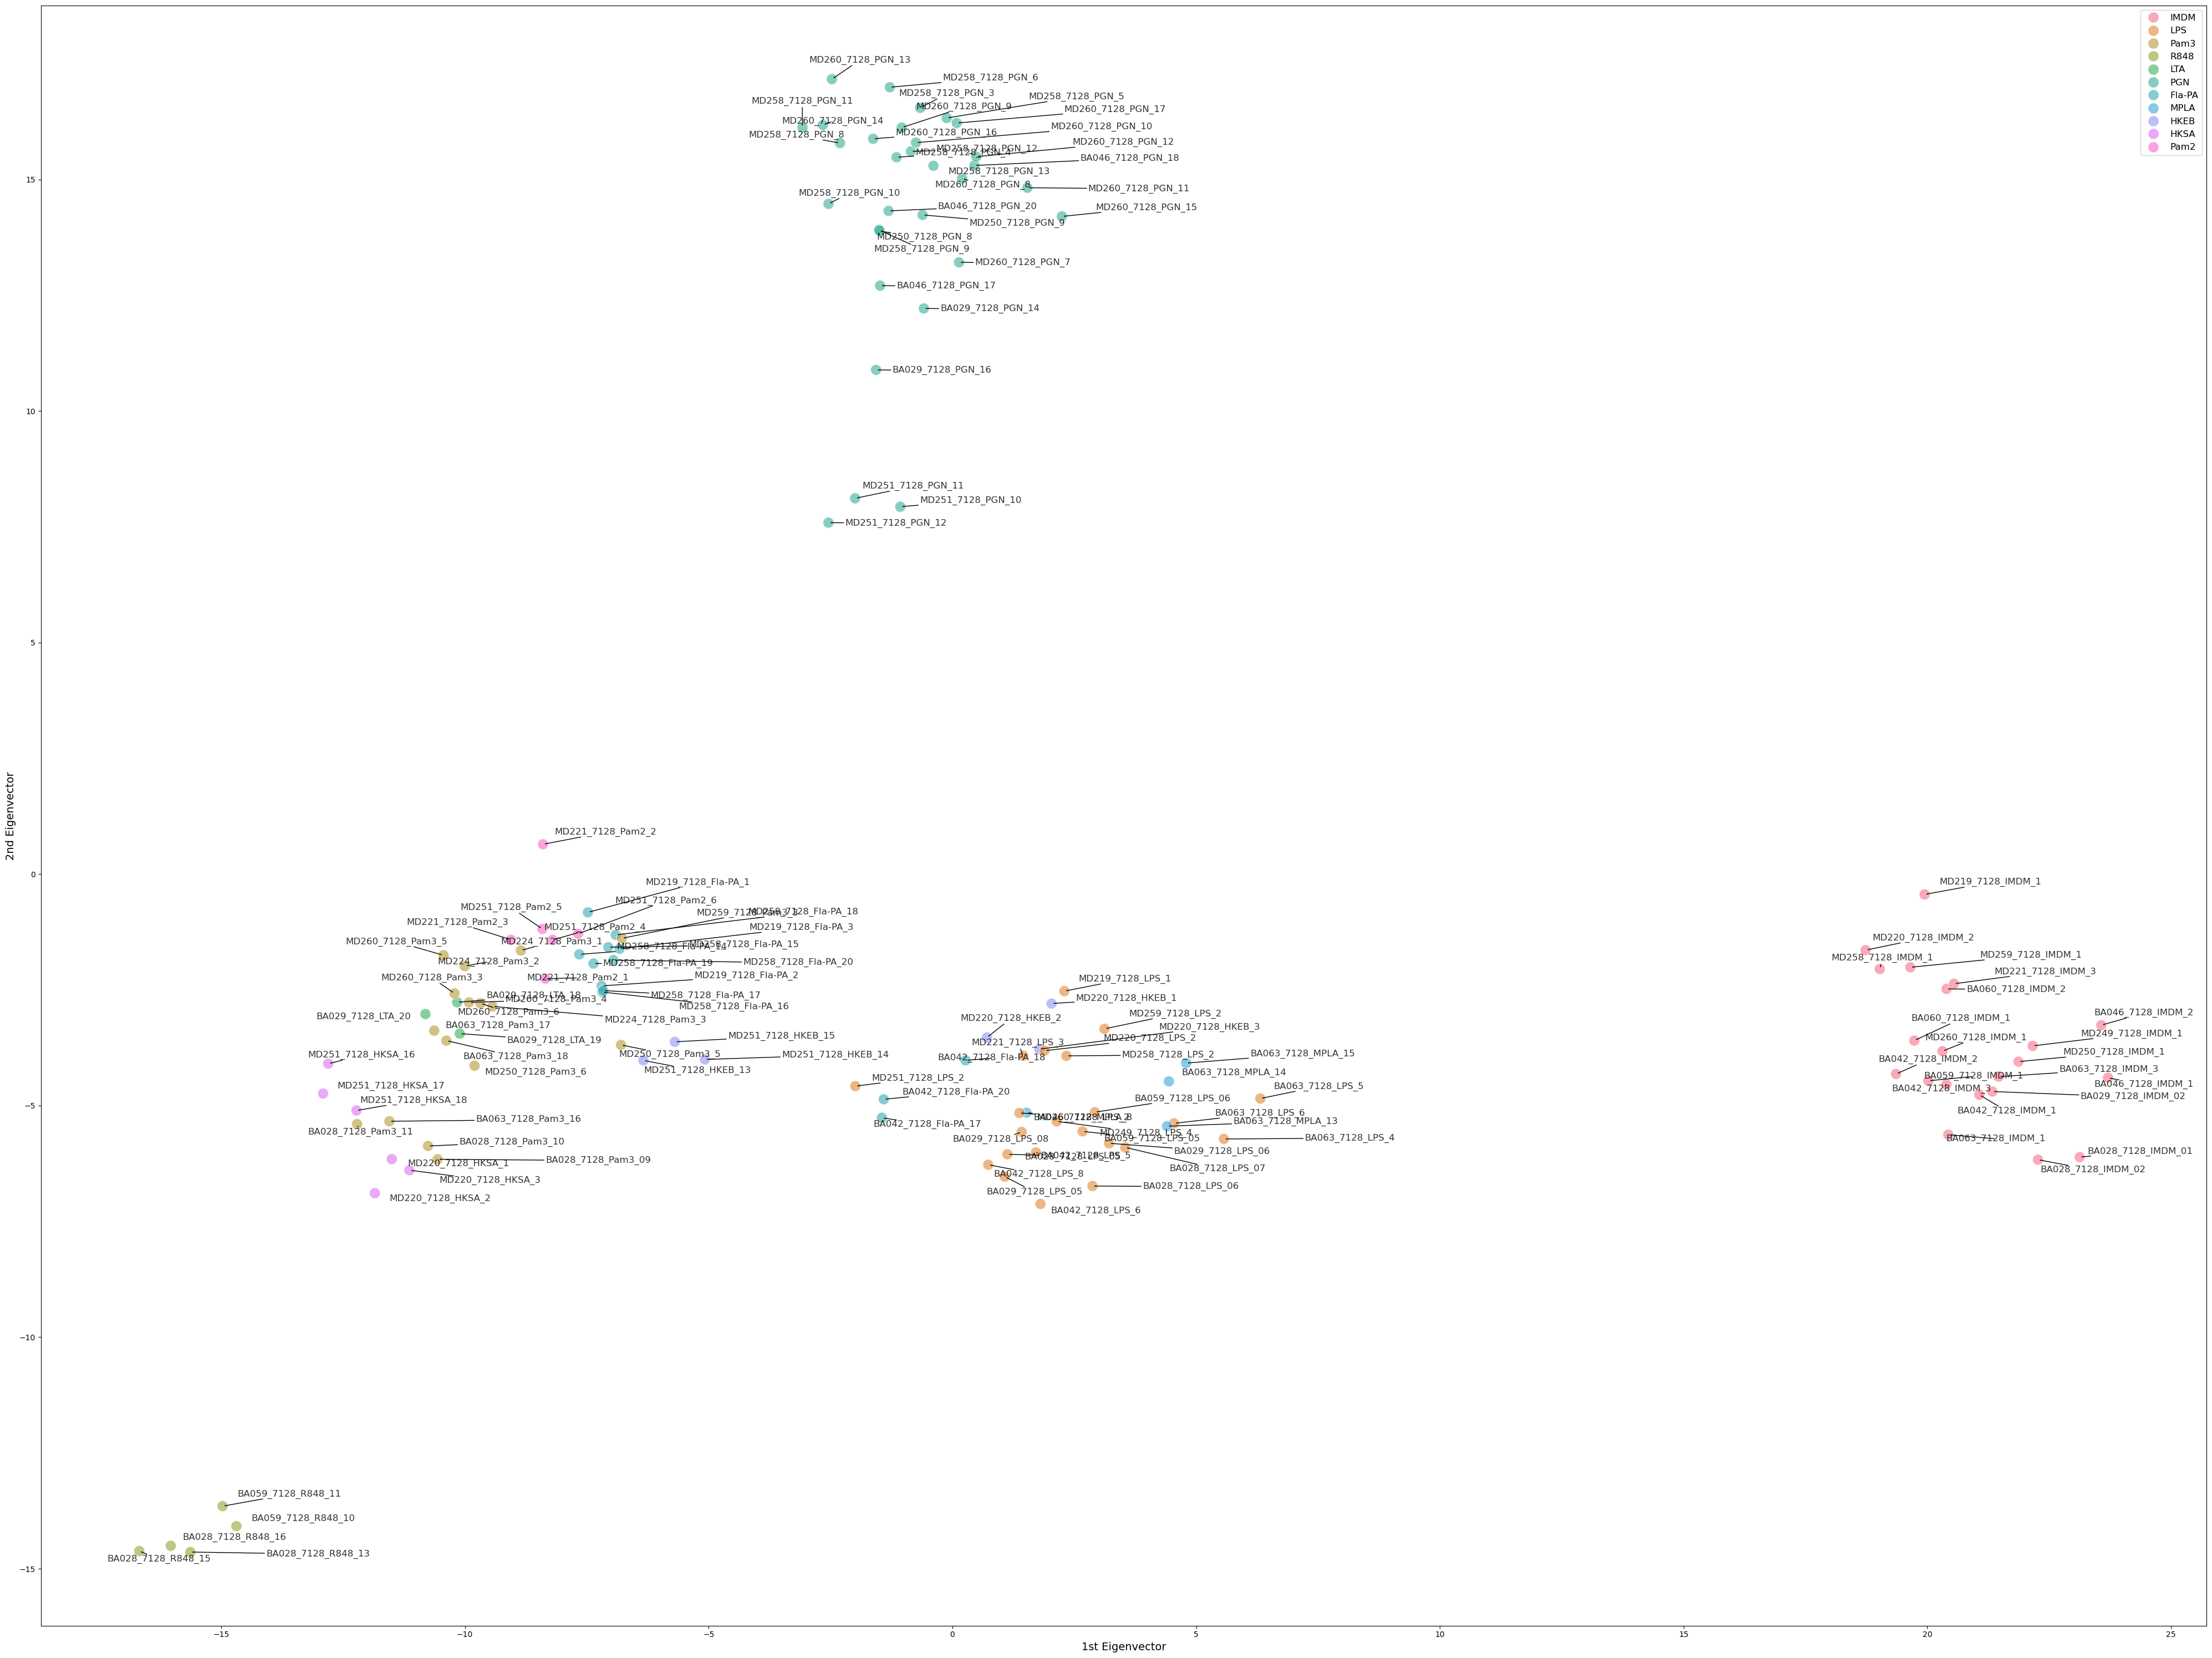

In [18]:
fig = plt.figure(figsize=(40, 30))
ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=labels["label"].to_numpy(),
    s=200,  # Increase dot size
    alpha=0.6,
)

texts = [
    ax.text(
        X_reduced[:, 0][i],
        X_reduced[:, 1][i],
        labels.index.to_numpy()[i],
        ha="left",
        va="bottom",
        alpha=0.8,
        fontsize=12,  # Increase font size
    )
    for i in range(len(X_reduced))
]

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="black"))

ax.set_xlabel("1st Eigenvector", fontsize=14)  # Increase font size
ax.set_ylabel("2nd Eigenvector", fontsize=14)  # Increase font size
ax.legend(bbox_to_anchor=(1, 1.0), ncol=1, fontsize=12)  # Increase legend font size
save_fig("PCA_plot_all_data")
plt.tight_layout()
plt.show()

## Training batch 7128

In [46]:
# prepare_training function now imported from src.preprocessing
training_data, training_labels = prepare_training(normalized_df)

In [ ]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(training_data)

X_reduced = PCA(n_components=2).fit_transform(scaled_df)
fig = plt.figure(figsize=(40, 30))
ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=labels["label"].to_numpy(),
    s=200,  # Increase dot size
    alpha=0.6,
)

# texts = [
#     ax.text(
#         X_reduced[:, 0][i],
#         X_reduced[:, 1][i],
#         labels.index.to_numpy()[i],
#         ha="left",
#         va="bottom",
#         alpha=0.8,
#         fontsize=12,  # Increase font size
#     )
#     for i in range(len(X_reduced))
# ]

# adjust_text(texts, arrowprops=dict(arrowstyle="->", color="black"))

ax.set_xlabel("1st Eigenvector", fontsize=14)  # Increase font size
ax.set_ylabel("2nd Eigenvector", fontsize=14)  # Increase font size
ax.legend(bbox_to_anchor=(1, 1.0), ncol=1, fontsize=12)  # Increase legend font size
save_fig("PCA_plot_all_data")
plt.tight_layout()
plt.show()

### PCA on training data

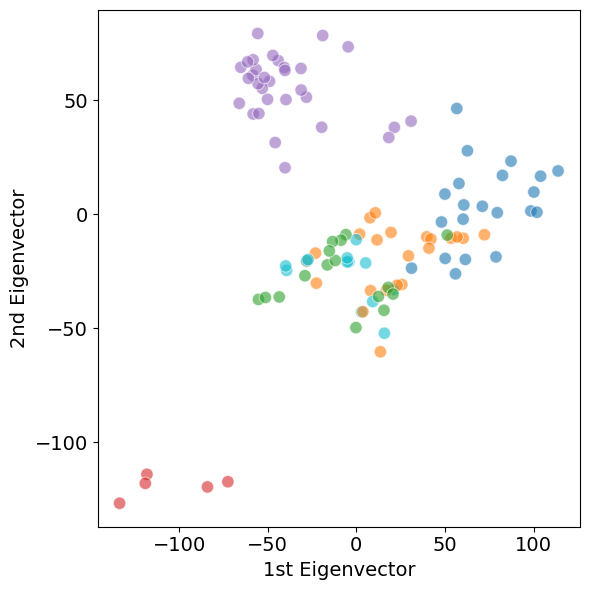

In [54]:
scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(training_data)

training_labels_int = le.fit_transform(training_labels["label"].to_numpy())

colors = [
    custom_palette_6[label % len(custom_palette_6)] for label in training_labels_int
]

fig = plt.figure(figsize=(6, 6))

X_reduced = PCA(n_components=2).fit_transform(scaled_training_data)

ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=training_labels["label"].to_numpy(),
    s=80,
    alpha=0.6,
    palette=custom_palette_6,
)
# texts = [
#     ax.text(
#         X_reduced[:, 0][i],
#         X_reduced[:, 1][i],
#         training_labels.index.to_numpy()[i],
#         ha="left",
#         va="bottom",
#         alpha=0.8,
#     )
#     for i in range(len(X_reduced))
# ]

# adjust_text(texts, arrowprops=dict(arrowstyle="->", color="black"))


ax.set_xlabel("1st Eigenvector", fontsize=14)
ax.set_ylabel("2nd Eigenvector", fontsize=14)
ax.tick_params(axis="both", labelsize=14)
ax.get_legend().remove()
plt.tight_layout()
plt.show()

/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


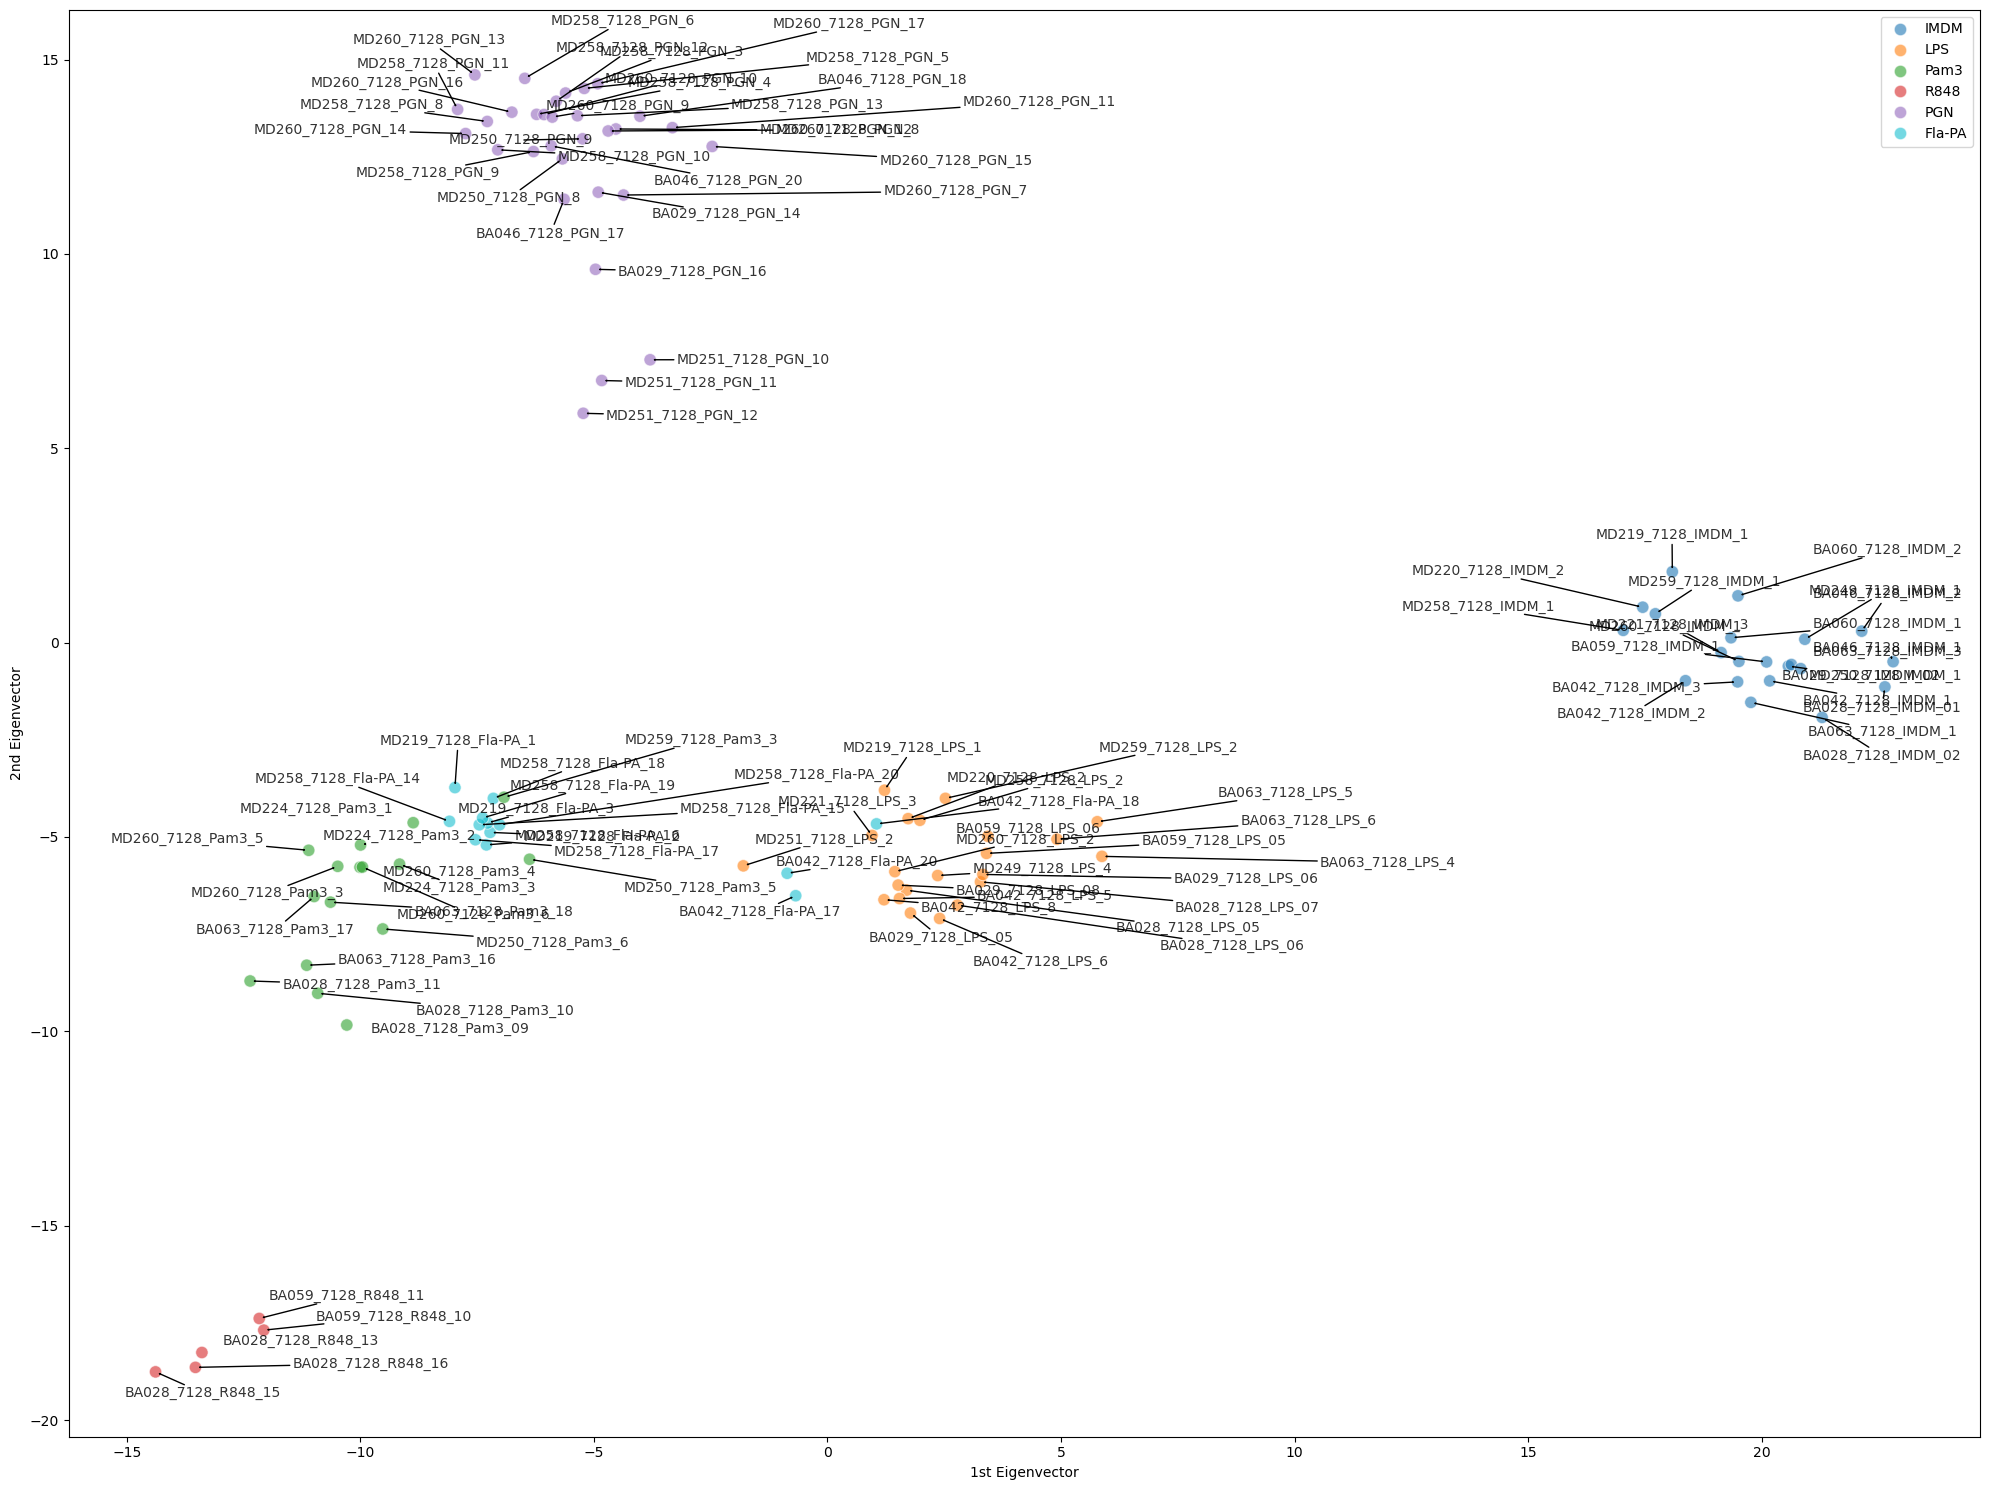

In [ ]:
processed_data = pipe.fit_transform(training_data, training_labels)
training_labels_int = le.fit_transform(training_labels["label"].to_numpy())


colors = [
    custom_palette_6[label % len(custom_palette_6)] for label in training_labels_int
]

fig = plt.figure(figsize=(20, 15))

X_reduced = PCA(n_components=2).fit_transform(processed_data)

ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=training_labels["label"].to_numpy(),
    s=80,
    alpha=0.6,
    palette=custom_palette_6,
)
texts = [
    ax.text(
        X_reduced[:, 0][i],
        X_reduced[:, 1][i],
        training_labels.index.to_numpy()[i],
        ha="left",
        va="bottom",
        alpha=0.8,
    )
    for i in range(len(X_reduced))
]

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="black"))

ax.set_xlabel("1st Eigenvector")
ax.set_ylabel("2nd Eigenvector")
ax.legend(bbox_to_anchor=(1, 1.0), ncol=1)
plt.tight_layout()
plt.show()

/home/t.afanasyeva/miniforge3/envs/MATseq/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


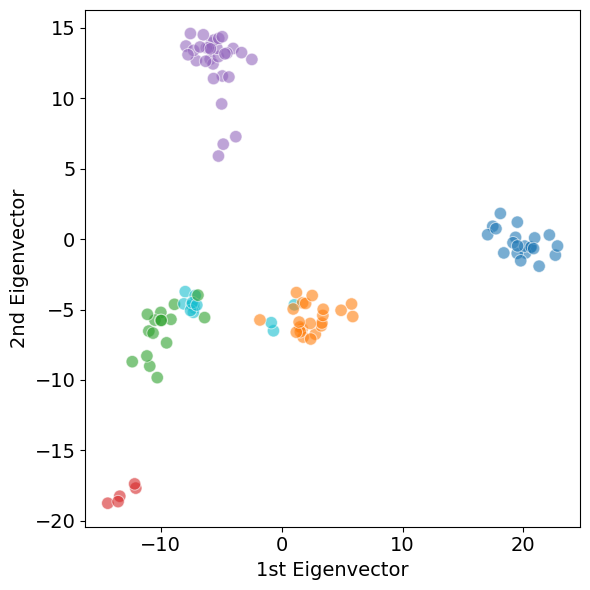

In [57]:
processed_data = pipe.fit_transform(training_data, training_labels)
training_labels_int = le.fit_transform(training_labels["label"].to_numpy())


colors = [
    custom_palette_6[label % len(custom_palette_6)] for label in training_labels_int
]

fig = plt.figure(figsize=(6, 6))

X_reduced = PCA(n_components=2).fit_transform(processed_data)

ax = sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=training_labels["label"].to_numpy(),
    s=80,
    alpha=0.6,
    palette=custom_palette_6,
)
ax.set_xlabel("1st Eigenvector", fontsize=14)
ax.set_ylabel("2nd Eigenvector", fontsize=14)
ax.tick_params(axis="both", labelsize=14)
ax.get_legend().remove()
plt.tight_layout()
plt.show()